In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
data_dir = '/kaggle/input/deepfake-and-real-images/Dataset'

In [3]:
os.listdir(data_dir)

['Validation', 'Test', 'Train']

In [4]:
print(len( os.listdir((os.path.join(data_dir,'Train','Real')))))
print(len( os.listdir((os.path.join(data_dir,'Train','Fake')))))

70001
70001


In [5]:
for image_class in os.listdir((os.path.join(data_dir,'Train','Real'))):
  print(image_class)
  break

real_58276.jpg


In [6]:
img = cv2.imread(os.path.join(data_dir,'Train','Real','real_58276.jpg'))

In [7]:
type(img)

numpy.ndarray

In [8]:
img.shape

(256, 256, 3)

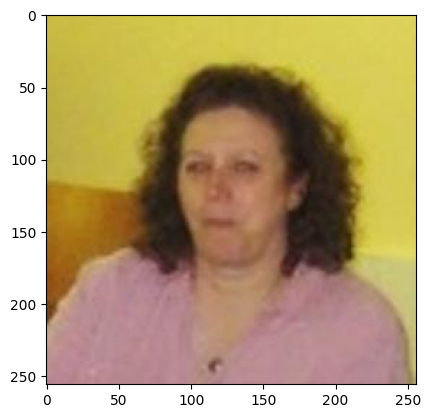

In [9]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [10]:
data_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 140002 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
print(len(batch))

2


In [14]:
#Images represented as Numpy Arrays
batch[0].shape

(32, 256, 256, 3)

In [15]:
batch[1]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0], dtype=int32)

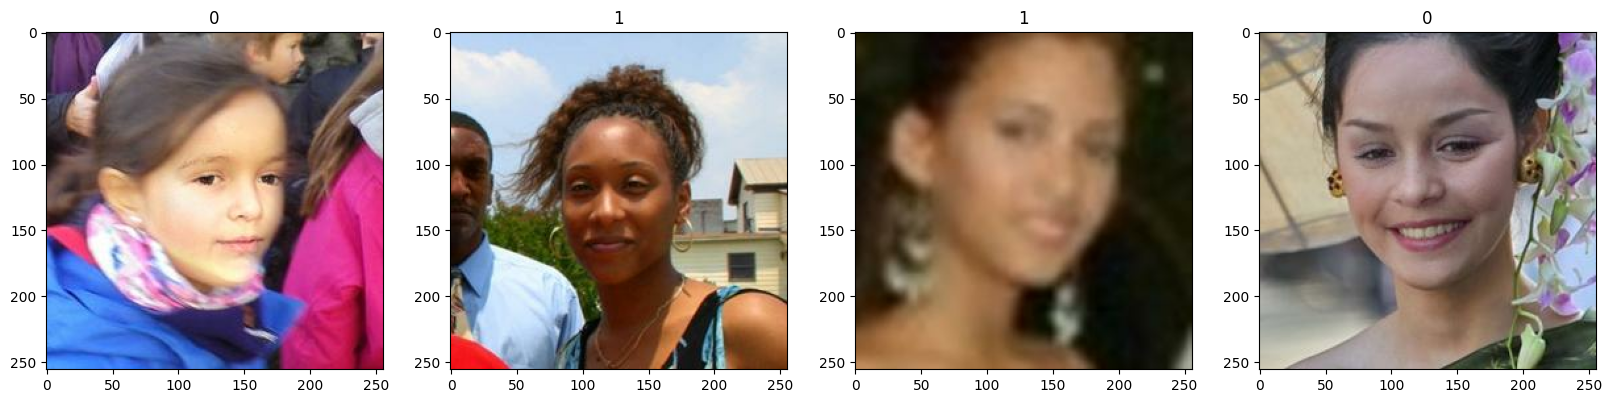

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [17]:
data = data.map(lambda x,y: (x/255,y))

In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
batch = scaled_iterator.next()

In [20]:
len(data)

4376

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [22]:
train_size+val_size+test_size

4375

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
model = Sequential()

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a CNN model
model = Sequential()

# Add convolutional layers and pooling layers
model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add fully connected layers with dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer with a dropout rate of 0.5

model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)       

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

3063/3063 [==============================] - 3248s 1s/step - loss: 0.3995 - accuracy: 0.8107 - val_loss: 0.2839 - val_accuracy: 0.8738


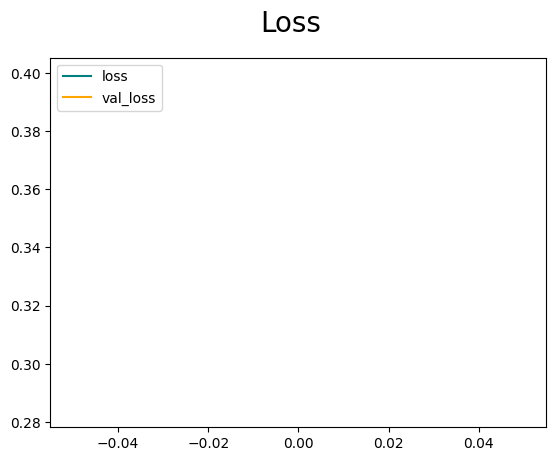

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

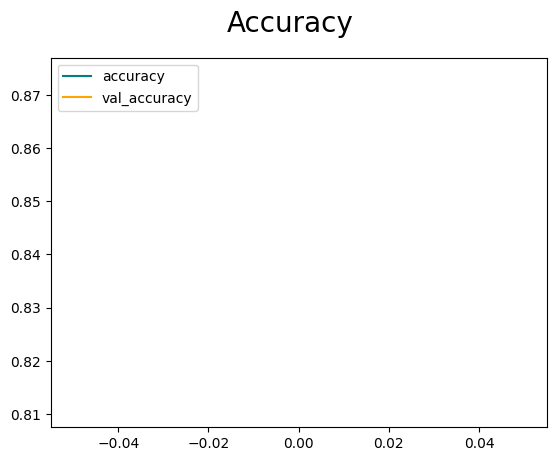

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
len(test)

437

In [35]:
for batch in test.as_numpy_iterator():
  X, y =batch
  yhat = model.predict(X)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)

1/1 [==============================] - 0s 286ms/step


In [36]:
print("Precision:",pre.result().numpy())
print("Recall:",re.result().numpy())
print("Accuracy:",acc.result().numpy())

Precision: 0.83405447
Recall: 0.9397763
Accuracy: 0.87671626


In [37]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score

# Assuming you have a test dataset or generator named 'test'
# and a pre-trained model named 'model'

pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.Accuracy()

# Initialize variables for collecting true labels and predicted labels
true_labels = []
predicted_labels = []

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

# Assuming you have a test dataset or generator named 'test'
# and a pre-trained model named 'model'

# Set the threshold for classification
threshold = 0.5

# Initialize variables for collecting true labels and predicted probabilities
true_labels = []
predicted_labels = []

# Iterate through the test data and calculate metrics
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Convert predicted probabilities to class labels using the threshold
    predicted_labels.extend((yhat >= threshold).astype(int))
    true_labels.extend(y)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(cm)
print("F1 Score:", f1)

1/1 [==============================] - 0s 293ms/step
Confusion Matrix:
[[5704 1299]
 [ 422 6559]]
F1 Score: 0.8764571047594644


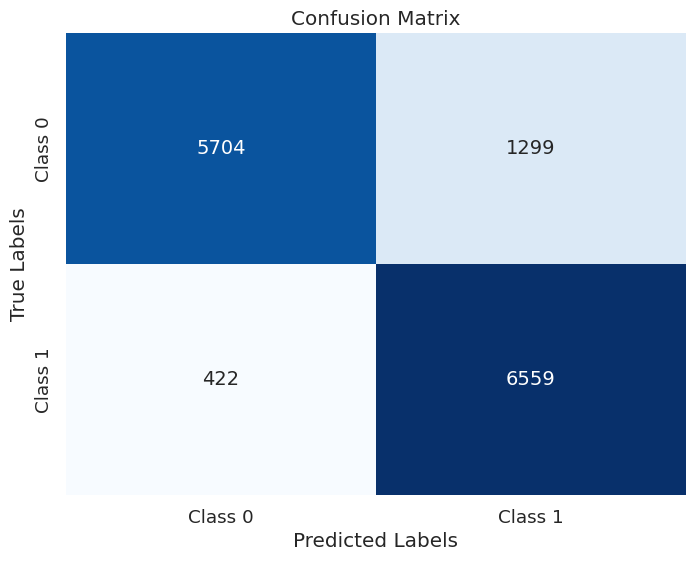

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the confusion matrix 'cm' calculated

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# import pickle

# # Assuming 'model' is the variable holding your model
# # For example, if 'model' is a scikit-learn classifier:
# # model = SomeClassifier()

# # Save the model to a file
# with open('model.pkl', 'wb') as file:
#     pickle.dump(model, file)
# file.close()

model.save('model.keras')


In [56]:
import pickle
from flask import Flask, request, jsonify
from PIL import Image
from io import BytesIO
import base64
import os
import numpy as np

# from flask_cors import CORS

app = Flask(__name__)
# CORS(app)

MODEL_PATH = 'model.pkl'  

with open(MODEL_PATH, 'rb') as f:
    model = pickle.load(f)

UPLOAD_FOLDER = 'DF\\uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

@app.route('/summary', methods=['POST'])
def process_image():
#     # Check if an image is included in the request
#     if 'image' not in request.form:
#         return jsonify({'error': 'No image provided'}), 400

#     # Get the base64 encoded image data from the request
#     image_data_base64 = request.form['image']

#     # Decode the base64 encoded image data
#     image_data = base64.b64decode(image_data_base64.split(',')[1])

#     # Convert the image data to a PIL Image object
#     pil_image = Image.open(BytesIO(image_data))

#     # Save the image to the uploads folder
#     image_path = os.path.join(app.config['UPLOAD_FOLDER'], 'process.jpg')
#     pil_image.save(image_path)

    preds=model_predict(input/jnjnjnjnjjbhb/process.png,model)
    print(preds)

    # Respond with a success message
    return jsonify({'message': preds, 'image_path': image_path}), 200



def model_predict(image, model):
    # Implement your prediction logic here
    # This function should return predictions based on the image and the model
    return model.predict(image)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=5000)



 * Serving Flask app '__main__'
 * Debug mode: off
